In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost.utils import get_gpu_device_count


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier  
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, StackingClassifier, VotingClassifier

In [2]:
print(xgb.__version__)
# Check GPU availability in XGBoost
params = {"tree_method": "hist"}
dtrain = xgb.DMatrix([[1, 2], [3, 4]], label=[0, 1])
bst = xgb.train(params, dtrain, num_boost_round=1)

2.1.4


## What this Program Does

< Insert a flow diagram on the entire workflow >

< Table about what each combination of Hyper parameters resulted in >

1. Loading and preprocessing the dataset.
2. Extracting handcrafted features (e.g., color histograms, texture descriptors).
3. Training and evaluating ML classifiers (SVM and Decision Tree).

## Hyperparameters :-

1. What dimension to resize all the images into :-  ( resized_width, resized_height )

## Models used :- 

- SVM
- Decision Tree
- Random Forest
- XGBoost
- LightGBM
- Gradient Boosting
- Bagging Classifier
- Voting Classifier
- Stacking Classifier

 LightGBM :-

- A fast, distributed, high performance gradient boosting (GBDT, GBRT, GBM or MART) framework 
- based on decision tree algorithms, 
- used for ranking, classification and many other machine learning tasks.

In [4]:
# Hyper-parameters
resized_width, resized_hieght = 64, 64

In [5]:
# Load Dataset
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            # Resize to a fixed size
            img = cv2.resize(img, (resized_width, resized_hieght))  
            images.append(img)
            labels.append(label)
    return images, labels

# Define Paths
mask_folder = "../data/with_mask_without_mask_classification/with_mask"
no_mask_folder = "../data/with_mask_without_mask_classification/without_mask"

# Load Images
mask_images, mask_labels = load_images_from_folder(mask_folder, 1)
no_mask_images, no_mask_labels = load_images_from_folder(no_mask_folder, 0)

In [6]:
# Combine Data
X = np.array(mask_images + no_mask_images)
y = np.array(mask_labels + no_mask_labels)

# Convert to grayscale for feature extraction
X_gray = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X])

## Perform EDA on both with_mask and no_mask ImageSet


Insights we are looking for while doing EDA :-
- Balanced dataset? → If one class has more images, we may need data augmentation.
- Image dimensions? → If sizes vary, we need to resize them before training.
- Visual check → Are the images clear? Do they have background noise?

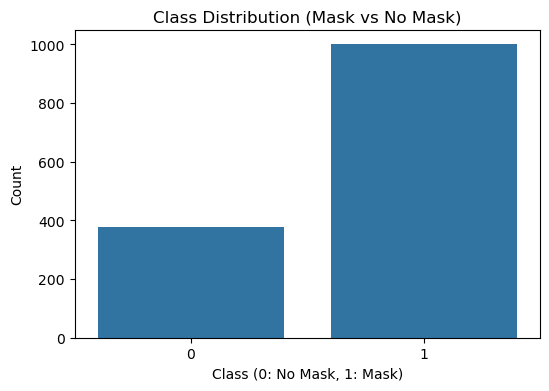

In [ ]:
# Convert to Numpy Array
X = np.array(X)
y = np.array(y)

# Plot Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Class Distribution (Mask vs No Mask)")
plt.xlabel("Class (0: No Mask, 1: Mask)")
plt.ylabel("Count")
plt.show()

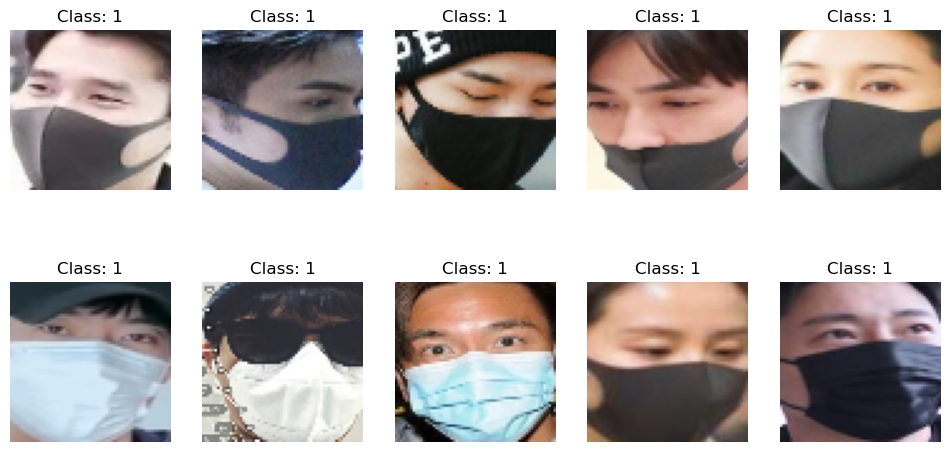

In [ ]:
# Display Some Sample Images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB))
    ax.set_title(f"Class: {y[i]}")
    ax.axis("off")
plt.show()

### HOG ( Histogram of Oriented Gradients ) 
HOG is a feature extraction technique that helps in recognizing objects. It works by:
1. Converting an image to grayscale (removing color information).
2. Computing gradients (edges) in different directions.
3. Creating histograms of these edge orientations for small parts of the image.
4. Combining all histograms into a single feature vector that represents the image

### How the below code works
- hog() extracts edge-based features from an image.
- orientations=8 → Calculates gradient directions in 8 bins.
- pixels_per_cell=(8, 8) → Divides the image into 8x8 pixel blocks.
- cells_per_block=(2, 2) → Groups 2x2 cells together for normalization.
- The output is a numerical representation of the image, which can be used for ML classification.

In [ ]:
# Extract Features - Histogram of Oriented Gradients (HOG)
from skimage.feature import hog

def extract_hog_features(images):
    features = []
    for img in images:
        feature, _ = hog(img, orientations=8, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True)
        features.append(feature)
    return np.array(features)

X_features = extract_hog_features(X_gray)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

In [ ]:
models = {
    'SVM': SVC(kernel='linear'),
    'Decision Tree': DecisionTreeClassifier(),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        tree_method="hist",         # Enables GPU acceleration
        predictor="gpu_predictor",  # Uses GPU for predictions 
        gpu_id=0                    # Ensure it runs on GPU
    ),
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=100,           # Reduced from 200
        max_depth=4,                # Reduced from 6 
        learning_rate=0.05,         # Reduced from 0.1
        min_child_samples=20,       # Minimum samples in a leaf
        subsample=0.8,              # Use 80% of data for trees
        colsample_bytree=0.8,       # Use 80% of features per tree
        class_weight='balanced',    # Handle class imbalance
        reg_alpha=0.1,              # L1 regularization
        reg_lambda=0.1,             # L2 regularization
        random_state=42,            # For reproducibility
    ),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, max_depth=6, learning_rate=0.1),
    'Bagging': BaggingClassifier(estimator=SVC(), n_estimators=10),
    'AdaBoost': AdaBoostClassifier(n_estimators=200, learning_rate=0.1),
    'CatBoost': CatBoostClassifier(iterations=200, depth=6, learning_rate=0.1, verbose=0, task_type="GPU")
}

print("XGBoost GPU ID:", models['XGBoost'].get_params()["gpu_id"])  # Should print 0
print("Available GPUs as seen CatBoost:", get_gpu_device_count())  # Should return >0 if GPU is available

XGBoost GPU ID: 0
Available GPUs as seen CatBoost: 1


# Model Definition

In [ ]:
# Train and Evaluate
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

SVM Accuracy: 0.9167
Decision Tree Accuracy: 0.7536


/home/nira/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:49:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/home/nira/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:49:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/nira/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:49:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is runn

XGBoost Accuracy: 0.9167
[LightGBM] [Info] Number of positive: 808, number of negative: 295
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 399765
[LightGBM] [Info] Number of data points in the train set: 1103, number of used features: 1568
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/home/nira/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Random Forest Accuracy: 0.8986
Gradient Boosting Accuracy: 0.9094
Bagging Accuracy: 0.9312
AdaBoost Accuracy: 0.8949
CatBoost Accuracy: 0.9239


## HPO ( Hyper Parameter Optimization )
- GridSearchCV → Tests all possible hyperparameter combinations (best for small search spaces).
- RandomizedSearchCV → Randomly picks hyperparameter combinations (faster for large search spaces).


what exactly does these 2 do :- do they train the model for each of the hyperparameter ? how do they really work ?

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
tuned_models = {}

In [ ]:

# ============ 5️⃣ AdaBoost ============

adaboost_params = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'estimator__max_depth': [1, 2, 3],  # For Decision Tree base estimator
}

# Create a base estimator explicitly
base_estimator = DecisionTreeClassifier(max_depth=1)  # Default for AdaBoost

# Create AdaBoost with the renamed parameter
adaboost = AdaBoostClassifier(estimator=base_estimator)

# Create the grid search
adaboost_grid = GridSearchCV(
    adaboost, 
    adaboost_params, 
    cv=5, 
    n_jobs=-1,
    scoring='accuracy'  # Or another metric like 'f1', 'roc_auc', etc.
)

# Fit the grid search
adaboost_grid.fit(X_train, y_train)
tuned_models["AdaBoost"] = adaboost_grid.best_estimator_
print("Best AdaBoost Parameters:", adaboost_grid.best_params_)

Best AdaBoost Parameters: {'estimator__max_depth': 3, 'learning_rate': 0.2, 'n_estimators': 300}


In [ ]:
# ============ 6️⃣ CatBoost ============
catboost_params = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2]
}

catboost_random = RandomizedSearchCV(CatBoostClassifier(verbose=0), catboost_params, cv=5, n_iter=10, n_jobs=-1, random_state=42)
catboost_random.fit(X_train, y_train)
tuned_models["CatBoost"] = catboost_random.best_estimator_
print("Best CatBoost Parameters:", catboost_random.best_params_)

In [ ]:
# ============ 1️⃣ Support Vector Machine (SVM) ============
svm_params = {
    'C': [0.1, 1, 10, 100],  # Regularization
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

svm_grid = GridSearchCV(SVC(), svm_params, cv=5, n_jobs=-1)
svm_grid.fit(X_train, y_train)
tuned_models['SVM'] = svm_grid.best_estimator_
print("Best SVM Parameters:", svm_grid.best_params_)

Best SVM Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}


In [ ]:
# ============ 2️⃣ Decision Tree ============
dt_params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

dt_random = RandomizedSearchCV(DecisionTreeClassifier(), dt_params, cv=5, n_iter=10, n_jobs=-1, random_state=42)
dt_random.fit(X_train, y_train)
tuned_models['Decision Tree'] = dt_random.best_estimator_
print("Best Decision Tree Parameters:", dt_random.best_params_)

Best Decision Tree Parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5}


In [ ]:
# ============ 3️⃣ Random Forest ============
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, n_jobs=-1)
rf_grid.fit(X_train, y_train)
tuned_models["Random Forest"] = rf_grid.best_estimator_
print("Best Random Forest Parameters:", rf_grid.best_params_)

Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# ============ 4️⃣ XGBoost ============
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}

xgb_random = RandomizedSearchCV(xgb.XGBClassifier(), xgb_params, cv=5, n_iter=10, n_jobs=-1, random_state=42)
xgb_random.fit(X_train, y_train)
tuned_models["XGBoost"] = xgb_random.best_estimator_
print("Best XGBoost Parameters:", xgb_random.best_params_)

Best XGBoost Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}


## After HPO, we use those parameters to do Stacking and Voting

In [ ]:
base_models = [
    ('svm', tuned_models['SVM']),  
    ('dt', tuned_models['Decision Tree']),
    ('rf', tuned_models['Random Forest']),
    ('xgb', tuned_models['XGBoost'])
    ('ada', tuned_models['AdaBoost']), 
    ('cat', tuned_models['CatBoost'])  
]

# Meta-Classifier (Final Model)
meta_classifier = LogisticRegression()

In [ ]:
# Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_classifier)

# Train & Evaluate
stacking_clf.fit(X_train, y_train)
y_pred_stacking = stacking_clf.predict(X_test)

stacking_acc = accuracy_score(y_test, y_pred_stacking)
print(f"Stacking Classifier Accuracy: {stacking_acc:.4f}")

In [ ]:
# Ensemble - Voting Classifier
voting_clf = VotingClassifier(estimators=base_models, voting='soft')


voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
voting_acc = accuracy_score(y_test, y_pred_voting)
print(f"Voting Classifier Accuracy: {voting_acc:.4f}")